In [6]:
import numpy as np

import cmath

import matplotlib.pyplot as plt

import time

from poliastro.twobody.events import LithobrakeEvent
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.util import norm
from poliastro.constants import R_earth, R_mean_earth, GM_earth
from poliastro.core.elements import coe2rv
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time

from datetime import datetime, timedelta
from sso_inc import inc_from_alt, raan_from_ltan,angle_between, argl_difference
from perturbations import perturbations_coesa_J2_high, perturbations_coesa_J2_low, perturbations_coesa_J2_med

from osc2mean_dd import osc2mean

from scipy.optimize import line_search

toc = time.time()
## Orbit
h = 400
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

pred_days = 10

delta_a = 1
delta_nu = 0

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

reference_orbit = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch
    )
trailing_orbit = Orbit.from_classical(
    Earth,
    a+(delta_a<<u.km),
    ecc,
    inc,
    raan,
    argp,
    nu+(delta_nu<<u.deg),
    epoch
    )

# Prop
start_date_ts = datetime.timestamp(start_date)
stop_date_ts = datetime.timestamp(start_date + timedelta(hours = 24*7*50))
sample_num = 9*1*16 #*7*2
timestamps = np.linspace(start_date_ts, stop_date_ts, sample_num)
time_step = (timestamps[1]-timestamps[0]) << u.s

refsmalist = []
refsmalist_mean = []
trailsmalist = []
trailsmalist_mean = []

assignment = 10

elapsedsecs = []
secs = 0

angle_list = []

ref_mean = osc2mean(reference_orbit.a.value, reference_orbit.ecc.value, reference_orbit.inc.to_value(u.deg), reference_orbit.raan.to_value(u.deg), reference_orbit.argp.to_value(u.deg), reference_orbit.nu.to_value(u.deg))
trail_mean = osc2mean(trailing_orbit.a.value, trailing_orbit.ecc.value, trailing_orbit.inc.to_value(u.deg), trailing_orbit.raan.to_value(u.deg), trailing_orbit.argp.to_value(u.deg), trailing_orbit.nu.to_value(u.deg))

test = True

for timestamp in range(len(timestamps)):

    ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, reference_orbit.nu.to(u.deg), reference_orbit.epoch)
    trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, trailing_orbit.nu.to(u.deg), trailing_orbit.epoch)
     
    secs += time_step.value
    tra_orb_10days = trail_mean_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_med))
    tra_10days_mean = osc2mean(tra_orb_10days.a.value, tra_orb_10days.ecc.value, tra_orb_10days.inc.to_value(u.deg), tra_orb_10days.raan.to_value(u.deg), tra_orb_10days.argp.to_value(u.deg), tra_orb_10days.nu.to_value(u.deg))
    tra_orb_10days_mean = Orbit.from_classical(Earth, tra_10days_mean[0]<<u.km, tra_10days_mean[1]<<u.one, tra_10days_mean[2]<<u.deg, tra_10days_mean[3]<<u.deg, tra_10days_mean[4]<<u.deg, tra_orb_10days.nu.to(u.deg), tra_orb_10days.epoch)

    a_err = trail_mean_orbit.a.value - ref_mean_orbit.a.value
    theta_err = (assignment - argl_difference(reference_orbit, trailing_orbit))%360
    #theta_err = (20 - ref_mean_orbit.nu.to_value(u.deg) - trail_mean_orbit.nu.to_value(u.deg))%360

    a_dot_rel = (trail_mean_orbit.a.value - tra_orb_10days_mean.a.value) / (pred_days*24*60*60)

    t_theta = (theta_err) / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s))
    t_a = a_err / a_dot_rel
    
    reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_med))

    if t_theta > t_a and test:
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low))
    else:
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))  
        test = False

    elapsedsecs.append(secs)
    refsmalist.append(reference_orbit.a.value)
    trailsmalist.append(trailing_orbit.a.value)

    ref_mean = osc2mean(reference_orbit.a.value, reference_orbit.ecc.value, reference_orbit.inc.to_value(u.deg), reference_orbit.raan.to_value(u.deg), reference_orbit.argp.to_value(u.deg), reference_orbit.nu.to_value(u.deg))
    trail_mean = osc2mean(trailing_orbit.a.value, trailing_orbit.ecc.value, trailing_orbit.inc.to_value(u.deg), trailing_orbit.raan.to_value(u.deg), trailing_orbit.argp.to_value(u.deg), trailing_orbit.nu.to_value(u.deg))

    refsmalist_mean.append(ref_mean[0])
    trailsmalist_mean.append(trail_mean[0])
    
    angle_list.append(argl_difference(reference_orbit, trailing_orbit))


elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')

ax[0,1].plot(elapsed_days,trailsmalist_mean,label='Trail')
ax[0,1].plot(elapsed_days,refsmalist_mean,label='Ref')
ax[0,1].set_title('Ref vs Reail Mean SMA')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()
      

Timestep 211468.5315 ss
Run time 676.38s/11.27m


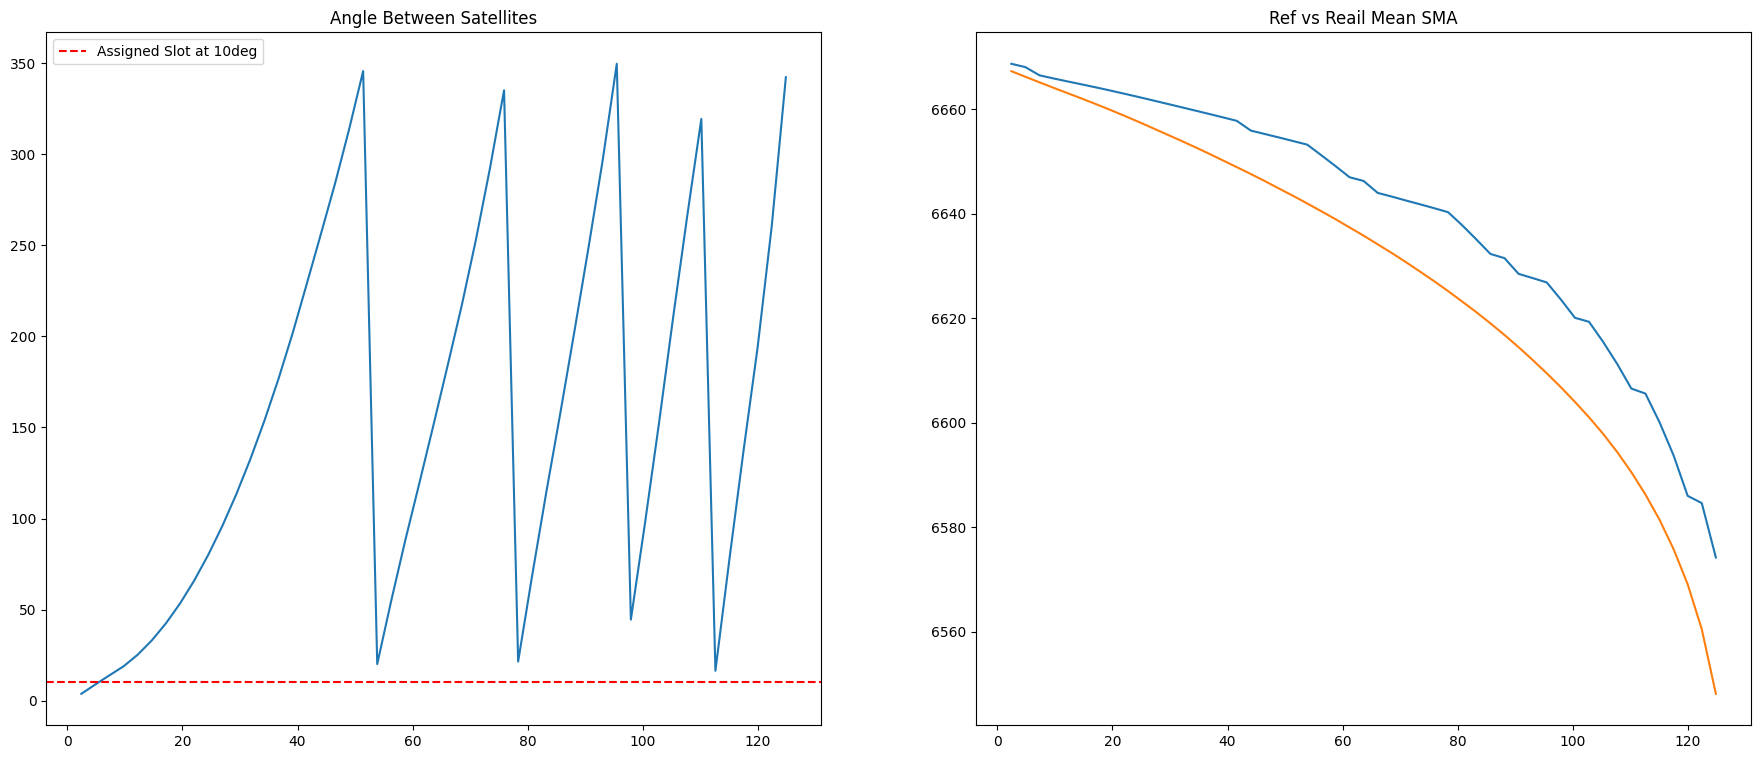

In [2]:
elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')

ax[0,1].plot(elapsed_days,trailsmalist_mean,label='Trail')
ax[0,1].plot(elapsed_days,refsmalist_mean,label='Ref')
ax[0,1].set_title('Ref vs Reail Mean SMA')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()
      